In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import networkx as nx
from collections import Counter
from sklearn.preprocessing import MinMaxScaler 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

Load data

In [2]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

org_sig_df = sig_df.copy()
org_bkg_df = bkg_df.copy()

full_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Only include leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

# Truth matching and cuts
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (bkg_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)
full_df = combined_df.copy()

# Define daughter and jet-level features, including sv tagging
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

In [64]:
for col in daughter_cols:
    full_df[col] = full_df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

In [217]:
# Split data 80:20 w equal parts sig/bkg then shuffle
sig_df = full_df[full_df['IsB'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = full_df[full_df['IsB'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

train_size = 160000
test_size = 40000

train_df = pd.concat([sig_df.head(train_size), bkg_df.head(train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(test_size), bkg_df.tail(test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([sig_df.iloc[train_size:-test_size], bkg_df.iloc[train_size:-test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)

In [175]:
train_sig_df = train_df[train_df['IsB'] == 1]
train_bkg_df = train_df[train_df['IsB'] == 0]

In [176]:
full_sig_df = full_df[full_df['IsB'] == 1]
full_bkg_df = full_df[full_df['IsB'] == 0]

In [170]:
full_sig_df = full_sig_df.head(200000)

In [67]:
full_bkg_df = full_bkg_df.head(200000)

Plot features data

In [181]:
def get_lists(col):
    sig_list = []
    bkg_list = []

    for i, row in train_sig_df.iterrows():
        vals = row[col]
        if isinstance(vals, list):
            sig_list.extend(vals)
        else:
            sig_list.append(vals)

    for i, row in train_bkg_df.iterrows():
        vals = row[col]
        if isinstance(vals, list):
            bkg_list.extend(vals)
        else:
            bkg_list.append(vals)
    return sig_list, bkg_list

In [182]:
important_features = ['Jet0_Daughters_E',
'Jet0_Daughters_pT',
'Jet0_Daughters_pZ',
'Jet0_Daughters_IPCHI2',
'Jet0_Daughters_NNmu',
'Jet0_Daughters_trackZ',
'Jet0_Daughters_trackVZ',
'Jet0_Daughters_CaloNeutralEcal',
'Jet0_Daughters_CaloNeutralHcal2Ecal',
'Jet0_Daughters_CaloNeutralE49',
'Jet0_Daughters_CaloNeutralPrs',
'Jet0_PT',
'Jet0_SVtag_m',
'Jet0_SVtag_mCor',
'Jet0_SVtag_fdChi2',
'Jet0_SVtag_ipChi2Sum',
'Jet0_SVtag_pt']

In [183]:
E_sig, E_bkg = get_lists('Jet0_Daughters_E')

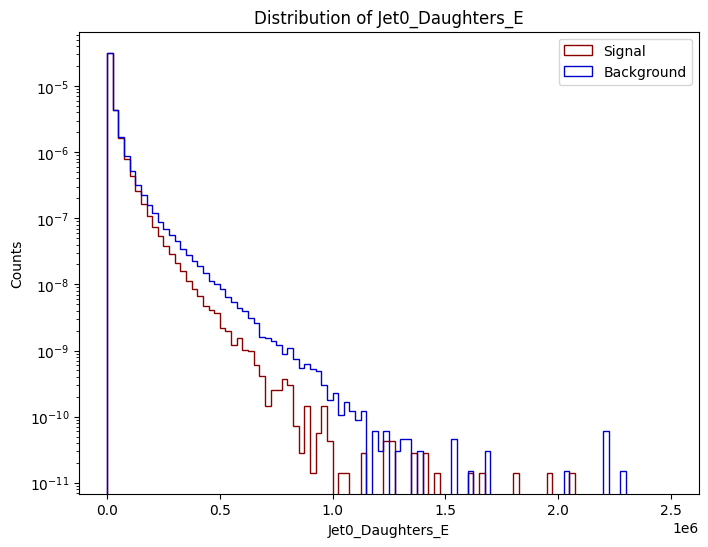

In [184]:
plt.figure(figsize=(8, 6))
plt.hist(E_sig, label="Signal", range=[0,2.5e6], bins=100, histtype='step', color='darkred', density=True)
plt.hist(E_bkg, label="Background", range=[0,2.5e6], bins=100, histtype='step', color='mediumblue', density=True)
plt.xlabel('Jet0_Daughters_E')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Distribution of Jet0_Daughters_E')
plt.legend(loc='best')
plt.show()

In [185]:
PT_sig, PT_bkg = get_lists('Jet0_PT')

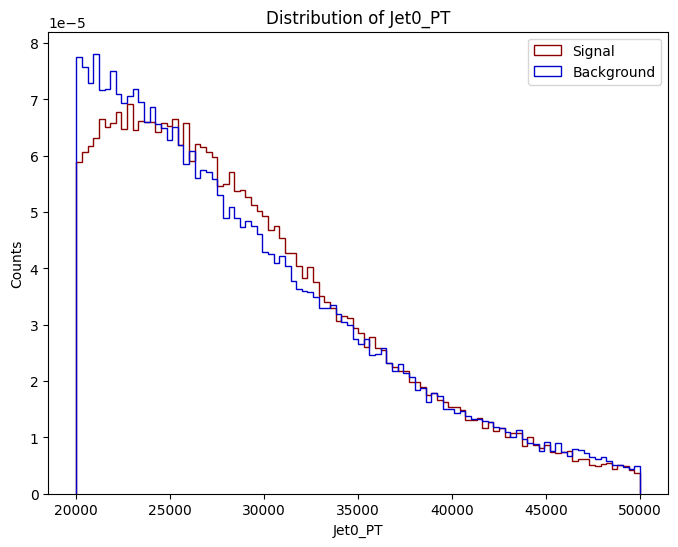

In [186]:
plt.figure(figsize=(8, 6))
plt.hist(PT_sig, label="Signal", range=[20000,50000], bins=100, histtype='step', color='darkred', density=True)
plt.hist(PT_bkg, label="Background", range=[20000,50000], bins=100, histtype='step', color='mediumblue', density=True)
plt.xlabel('Jet0_PT')
plt.ylabel('Counts')
plt.yscale('linear')
plt.title('Distribution of Jet0_PT')
plt.legend(loc='best')
plt.show()

In [187]:
def plot_features(col, scale, range, bins):
    sig_list, bkg_list = get_lists(col)

    plt.figure(figsize=(8, 6))
    plt.hist(sig_list, label="Signal", range=range, bins=bins, histtype='step', color='darkred', density=True)
    plt.hist(bkg_list, label="Background", range=range, bins=bins, histtype='step', color='mediumblue', density=True)
    plt.xlabel(f'{col}')
    plt.ylabel('Counts')
    plt.yscale(scale)
    plt.title(f'Distribution of {col}')
    plt.legend(loc='best')
    plt.show()

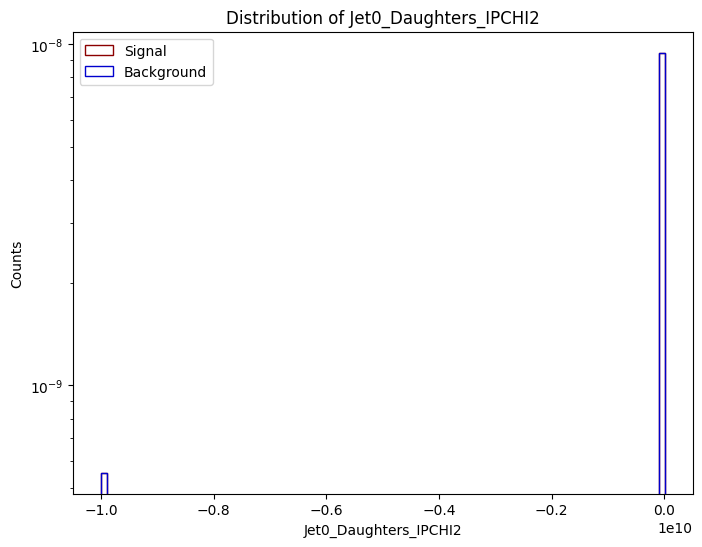

In [188]:
plot_features('Jet0_Daughters_IPCHI2', 'log', None, 100)

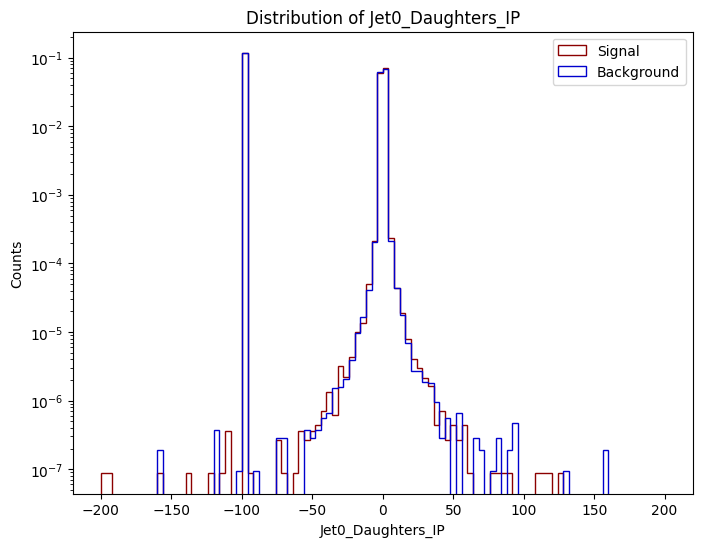

In [189]:
plot_features('Jet0_Daughters_IP', 'log', [-200, 200], 100)

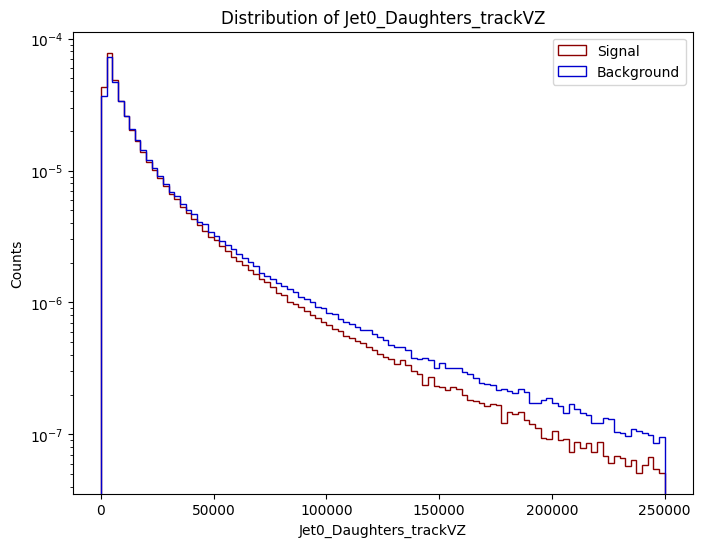

In [190]:
plot_features('Jet0_Daughters_trackVZ', 'log', [0,0.25e6], 100)

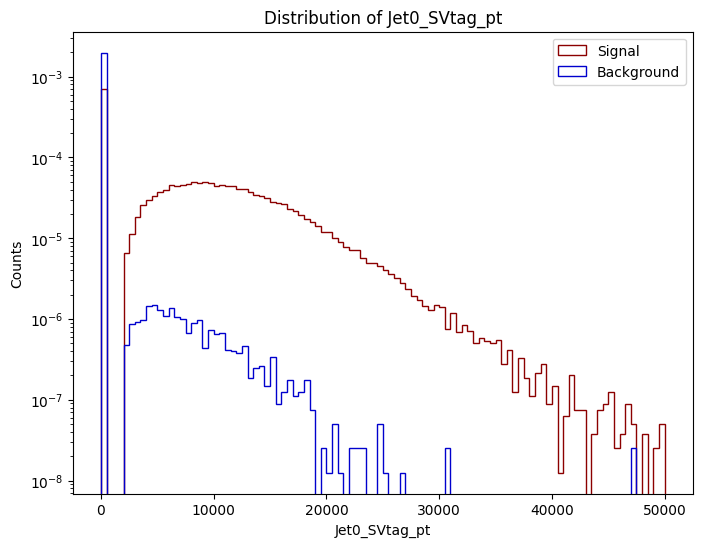

In [191]:
plot_features('Jet0_SVtag_pt', 'log', [0,50000], 100)

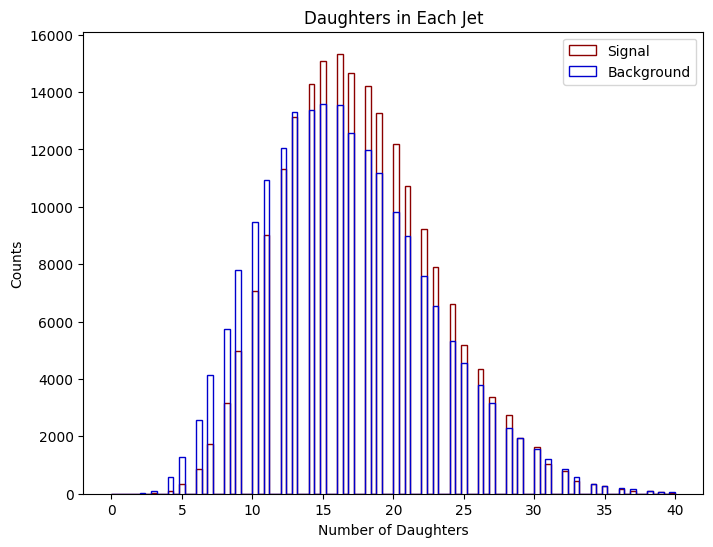

In [192]:
plt.figure(figsize=(8, 6))
plt.hist(sig_df.Jet0_nDaughters, label="Signal", range=[0,40], bins=100, histtype='step', color='darkred')
plt.hist(bkg_df.Jet0_nDaughters, label="Background", range=[0,40], bins=100, histtype='step', color='mediumblue')
plt.xlabel('Number of Daughters')
plt.ylabel("Counts")
plt.legend(loc='best')
plt.title('Daughters in Each Jet'); 
plt.show()

In [193]:
sig_id_list = []
bkg_id_list = []

for i, row in sig_df.iterrows():
    numbers = [float(num) for num in row['Jet0_Daughters_ID']]
    sig_id_list.extend(numbers)

for i, row in bkg_df.iterrows():
    numbers = [float(num) for num in row['Jet0_Daughters_ID']]
    bkg_id_list.extend(numbers)

In [194]:
sig_id_counts = Counter(sig_id_list)
bkg_id_counts = Counter(bkg_id_list)

In [195]:
sig_id_counts

Counter({22.0: 1491791,
         211.0: 709360,
         -211.0: 696576,
         -22.0: 202261,
         310.0: 118196,
         321.0: 87698,
         -321.0: 85976,
         -11.0: 45092,
         11.0: 43716,
         111.0: 34642,
         2212.0: 30573,
         -2212.0: 29271,
         -13.0: 16075,
         13.0: 15555,
         -3122.0: 14499,
         3122.0: 14096})

In [196]:
bkg_id_counts

Counter({22.0: 1381278,
         211.0: 688478,
         -211.0: 669762,
         -22.0: 188591,
         321.0: 85949,
         -321.0: 82774,
         310.0: 51431,
         2212.0: 50571,
         -2212.0: 48073,
         -11.0: 37685,
         11.0: 36189,
         111.0: 34957,
         -3122.0: 7618,
         3122.0: 7246,
         -13.0: 3171,
         13.0: 2985})

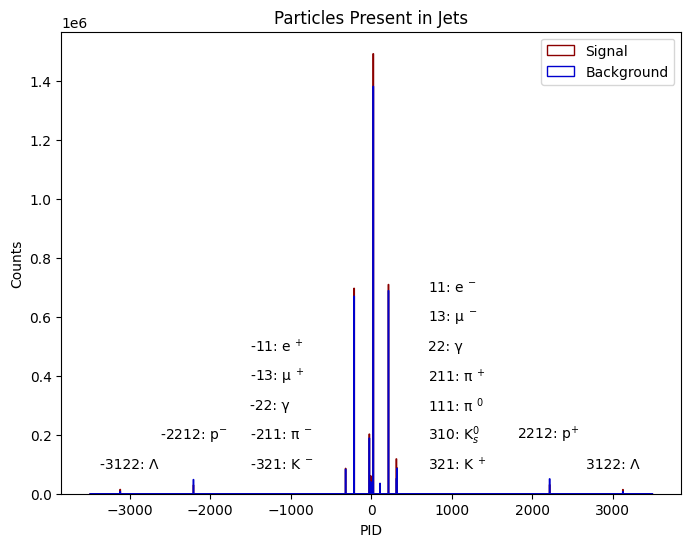

In [207]:
# Plot of Jet 0 Daughters PID (not including some outliers)
plt.figure(figsize=(8, 6))
plt.hist(sig_id_list, label='Signal', bins=1000, range=[-3500,3500], histtype='step', color='darkred')
plt.hist(bkg_id_list, label='Background', bins=1000, range=[-3500,3500], histtype='step', color='mediumblue')

plt.text(-3000, 100000, '-3122: Λ', horizontalalignment='center', verticalalignment='center')
plt.text(-2200, 200000, '-2212: p$^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-1500, 100000, '-321: K $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 200000, '-211: π $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 300000, '-22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 400000, '-13: µ $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 500000, '-11: e $^{+}$', horizontalalignment='left', verticalalignment='center')

plt.text(700, 700000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 600000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 500000, '22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(700, 400000, '211: π $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 300000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 200000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 100000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(2200, 200000, '2212: p$^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(3000, 100000, '3122: Λ', horizontalalignment='center', verticalalignment='center')

plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles Present in Jets');
plt.legend(loc='best');
plt.show()

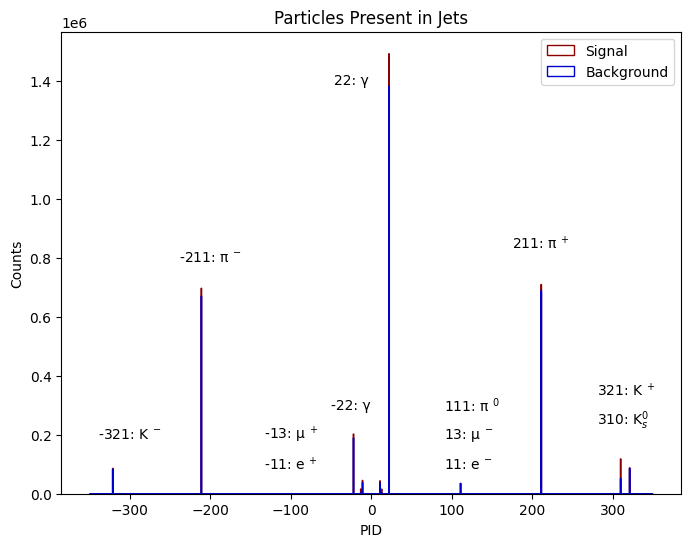

In [208]:
# Plot of Daughters PID in range of pions and kaons
plt.figure(figsize=(8, 6))
plt.hist(sig_id_list, label='Signal', bins=1000, range=[-350,350], histtype='step', color='darkred')
plt.hist(bkg_id_list, label='Background', bins=1000, range=[-350,350], histtype='step', color='mediumblue')

plt.text(-300, 200000, '-321: K $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-200, 800000, '-211: π $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-25, 300000, '-22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 200000, '-13: µ $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 100000, '-11: e $^{+}$', horizontalalignment='center', verticalalignment='center')

plt.text(90, 100000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(90, 200000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-25, 1400000, '22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(90, 300000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(211, 850000, '211: π $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(280, 250000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(280, 350000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')

plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles Present in Jets');
plt.legend(loc='best');
plt.show()

In [211]:
train_sig_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8375,-0.1526,2.9495,0.0100,0.0099,0.0585,43.323650,93,0.838157,-0.154143,...,True,True,True,True,True,True,True,True,True,1
6,0.8844,-0.1194,27.2368,0.0221,0.0236,0.1881,5.428807,9,0.805269,-0.161020,...,False,False,False,True,False,False,True,False,False,1
11,0.8732,-0.2200,19.6112,0.0115,0.0113,0.0671,30.734550,57,0.874999,-0.222397,...,True,True,True,True,True,True,True,True,True,1
15,0.8509,-0.1766,9.0353,0.0089,0.0088,0.0527,49.436974,123,0.849630,-0.176315,...,True,True,True,True,True,True,True,True,True,1
16,0.8555,-0.2122,38.5003,0.0080,0.0080,0.0387,42.971848,105,0.855500,-0.212200,...,True,True,True,True,True,True,True,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319994,0.8452,-0.1594,-16.8833,0.0111,0.0114,0.0665,37.007267,79,0.845063,-0.155155,...,True,True,True,True,True,True,True,True,True,1
319995,0.9282,-0.1552,-21.4546,0.0198,0.0207,0.1196,4.637649,13,0.868032,-0.196206,...,True,True,True,True,True,True,True,True,True,1
319997,0.8284,-0.1329,50.2082,0.0348,0.0238,0.3631,4.496447,13,0.824800,-0.229000,...,True,True,True,True,True,True,True,True,True,1
319998,0.8364,-0.2016,4.7028,0.0066,0.0065,0.0339,66.884567,171,0.837020,-0.202891,...,True,True,True,True,True,True,True,True,True,1


In [199]:
# Split data 80:20 w equal parts sig/bkg then shuffle
sig_df = full_df[full_df['IsB'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = full_df[full_df['IsB'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

train_size = 160000
test_size = 40000

train_df = pd.concat([sig_df.head(train_size), bkg_df.head(train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(test_size), bkg_df.tail(test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([sig_df.iloc[train_size:-test_size], bkg_df.iloc[train_size:-test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)

daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = [col for col in sig_df.columns if "SVtag" in col]
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

# Create node feature array: [jet][daughter][feature]
def node_features(df):
    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df)
test_features = node_features(test_df)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [200]:
# Print adjacency matric
G = nx.Graph()
G.add_edges_from(train_loader.dataset[0].edge_index.t().tolist())
A = nx.adjacency_matrix(G)
print(A.todense())

[[0 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 0]]


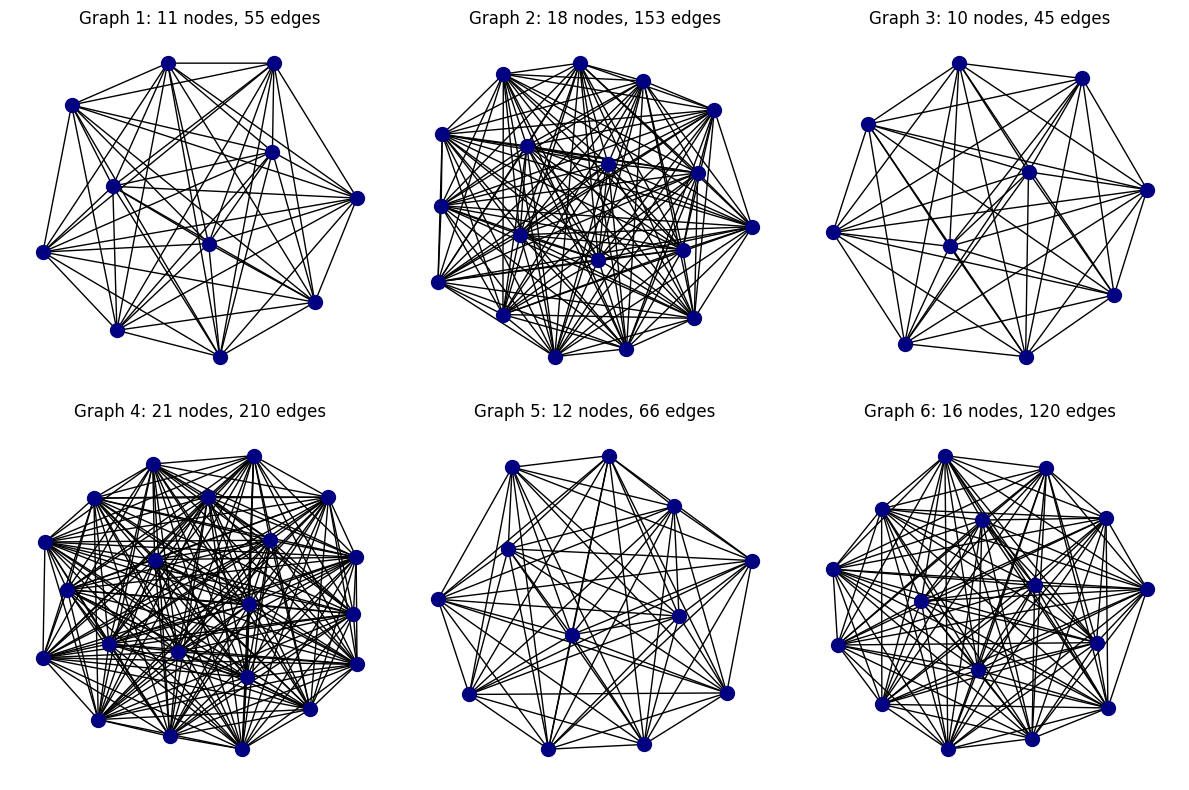

In [201]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], node_color='navy', node_size=100)
    
    axes[i].set_title(f"Graph {i+1}: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

plt.tight_layout()
plt.show()